In [2]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None)

# NLP
import nltk
from soynlp.normalizer import *
from hanspell import spell_checker
from konlpy.tag import Okt


# ML
import pprint
from sklearn.metrics import accuracy_score, precision_score , recall_score, f1_score, roc_curve, classification_report
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV, KFold, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

# 한글화
from matplotlib import font_manager, rc
path = 'C:/Windows/Fonts/malgun.ttf'
rc('font', family='Malgun Gothic')

---

## 전처리

In [ ]:
# 파일 불러오기

review_df = pd.read_csv('./review_all_stop2_haspell_nongood_tknized_rmved_seongeun.csv', encoding='utf-8', index_col=0)
review_df.head()

In [ ]:
review_df['label'] = [1 if rate >=4 else 0 for rate in review_df['rating']]
review_df.head()

In [54]:
review_df['reviews_for_vectorize'].sample(10)

2893                                                                             편하고 소스 종류 다양해서
4252                                                                                      만족합니다
5352                                                                                사용 편하고 좋습니다
9136                                                                                        편해요
1942                                                                                         할인
1086     배송 하루 면 오는 줄 알았는데 엊그제 13일 저녁 11시 시켰는데 15일 아침 왔고요 상담 원 분 14일 12시 자정 까지는 온다 해서 기다렸는데 왔네요
4327                                                                            쿠팡 보다 맛있고 가격 저렴
1594                                                         업데이트 하는지 장바구니 담아도 담아도 비었다고 장 못 봅니다
6140                                                                                         우아
1997                                                                                        편하고
Name: reviews_for_vectorize, dtype: obje

In [56]:
# 남아있는 숫자 제거
review_df['reviews_for_vectorize'] = review_df['reviews_for_vectorize'].apply(lambda x: normalize(x))
review_df['reviews_for_vectorize'][1086]

'배송 하루 면 오는 줄 알았는데 엊그제 일 저녁 시 시켰는데 일 아침 왔고요 상담 원 분 일 시 자정 까지는 온다 해서 기다렸는데 왔네요'

In [151]:
# 맞춤법 검사
errors = []

def spell_check(text):
    try:
        result = spell_checker.check(text)
        return result.checked
    except:
        errors.append(review_df[review_df['reviews_for_vectorize'] == text].index[0])
        return text  

review_df['reviews_for_vectorize'] = review_df['reviews_for_vectorize'].apply(spell_check)

In [155]:
# 토큰화 - 명사

review_df['reviews_for_vectorize'] = [ Okt().nouns(text) for text in review_df['reviews_for_vectorize'] ]

In [161]:
# 벡터화에 필요한 작업 (띄어쓰기 붙여주기)

contents_for_vectorize = []

for content in review_df['reviews_for_vectorize']: 
    sentence = ""
    for word in content:
        sentence = sentence + ' ' + word
        
    contents_for_vectorize.append(sentence)

review_df['reviews_for_vectorize'] = contents_for_vectorize

In [170]:
neworder = ['date', 'rating', 'label', 'reviews_for_vectorize']
review_df = review_df[neworder]
review_df.sample(10)

,date,rating,label,reviews_for_vectorize
1424,2022-07-26,1,0,업데이트 계속 로그아웃 제발 수정
9918,2020-02-20,5,1,배송 음식 메뉴 점점 한정
6887,2021-01-05,4,1,리뷰 보기 매우 게시판 접근성 별
8271,2020-07-22,5,1,찜 기능 리뷰 볼 사진 리뷰 볼 더
7148,2020-12-11,1,0,타깃 돈 가성 비 사람 억지
10495,2019-12-18,5,1,후기 보기 사진 후기 볼 기능 베스트 후기 제품 사진 후기 계속 스 크롤 말 대충 사진 외 배송 물건 이용
10079,2020-02-15,5,1,품질
9418,2020-04-02,4,1,듯 데 포인트 담날 새벽 아침 대형 마트 주문 때문 대략 정도 외출 대기 아침 문 앞 배송 대한 스트레스
5117,2021-06-13,3,0,업데이트 이후 계속 앱 에러 하나요
5135,2021-06-11,5,1,라즈베리 식초


In [171]:
len(review_df)

11288

In [172]:
review_df['label'].value_counts()

1    9062
0    2226
Name: label, dtype: int64

---

## 불용어 제거 및 학습실행 (반복)

In [284]:
with open('stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = f.readlines()
    stopwords = [word.strip() for word in stopwords]

def remove_stopwords(review):
    return ' '.join([word for word in review.split() if word not in stopwords])

review_df['reviews_for_vectorize'] = review_df['reviews_for_vectorize'].apply(remove_stopwords)
print('총 불용어 개수 : ' + str(len(stopwords)))


총 불용어 개수 : 1671


In [251]:
# Pipeline, Parameters 설정

X = review_df['reviews_for_vectorize']
y = review_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

skfold = StratifiedKFold(n_splits=5)

pipe_countvec = Pipeline([
                ('vec', CountVectorizer(decode_error='ignore')),
                ('fit', LogisticRegression())])

pipe_tfidfvec = Pipeline([
                ('vec', TfidfVectorizer(decode_error='ignore')),
                ('fit', LogisticRegression())])


min = [3,4,7]                       
max = [0.99, 0.98, 0.97, 0.96]
cs = [1, 2, 3, 50, 100]                   
max_iters = [800,1000,1200]     
penaltys = ['l2']               
solver = ["saga"]               
            
# l1 & l2 차이
# max_iters 1000이상은 의미없다

grid_params_countvec = [{
    "vec__min_df" : min,
    "vec__max_df" : max,
    "fit__C": cs,
    "fit__max_iter": max_iters,
    "fit__penalty" : penaltys,
    "fit__solver" : solver
}]

grid_params_tfidfvec = [{
    "vec__min_df" : min,
    "vec__max_df" : max,
    "fit__C": cs,
    "fit__max_iter": max_iters,
    "fit__penalty" : penaltys,
    "fit__solver" : solver
}]


pipe = [pipe_countvec , pipe_tfidfvec ]
params = [grid_params_countvec , grid_params_tfidfvec]

grid_dict = {
    0: 'Countvec', 
    1: 'Tfidfvec',
            }

In [252]:
# 실행
model_object = {}; model_acc = {}; model_preci = {}; model_recall = {}; model_f1 = {}; model_best_params = {}

for idx , (param , model) in enumerate(zip(params , pipe)) :
    search = GridSearchCV(model, param, scoring  = "f1", cv=skfold,
                           n_jobs=20 , verbose=True ) #  verbose가 있으면 함수 수행시 발생하는 상세한 정보 출력
    search.fit(X_train , y_train)
    y_pred = search.predict(X_test)
       
    model_object[grid_dict.get(idx)] = search
    model_acc[grid_dict.get(idx)] = accuracy_score(y_test, y_pred)  
    model_preci[grid_dict.get(idx)] = precision_score(y_test, y_pred)
    model_recall[grid_dict.get(idx)] = recall_score(y_test, y_pred)
    model_f1[grid_dict.get(idx)] = f1_score(y_test, y_pred)

    model_best_params[grid_dict.get(idx)] = search.best_params_
    
print("finish")

Fitting 5 folds for each of 180 candidates, totalling 900 fits


c:\Users\vivel\miniconda3\envs\ds_study\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fitting 5 folds for each of 180 candidates, totalling 900 fits
finish


In [253]:
print(f'Acc : {model_acc}')
print(f'Preci : {model_preci}')
print(f'Recall : {model_recall}')
print(f'F1 : {model_f1}')

for k, v in model_best_params.items():
    print(f'Best params {k} : {v}')

Acc : {'Countvec': 0.8919397697077059, 'Tfidfvec': 0.8985828166519043}
Preci : {'Countvec': 0.9070010449320794, 'Tfidfvec': 0.9124278972207656}
Recall : {'Countvec': 0.9633740288568258, 'Tfidfvec': 0.9655937846836848}
F1 : {'Countvec': 0.9343379978471474, 'Tfidfvec': 0.9382582906443786}
Best params Countvec : {'fit__C': 3, 'fit__max_iter': 800, 'fit__penalty': 'l2', 'fit__solver': 'saga', 'vec__max_df': 0.98, 'vec__min_df': 3}
Best params Tfidfvec : {'fit__C': 3, 'fit__max_iter': 800, 'fit__penalty': 'l2', 'fit__solver': 'saga', 'vec__max_df': 0.99, 'vec__min_df': 7}


### 학습 결과
#### 1차
max = [0.95, 0.90, 0.85]
cs = [1, 5, 10]                         
max_iters = [500, 1000, 1500]
penaltys = ['l1', 'l2']                  
solver = ["liblinear", "saga"]               
{'Countvec': 0.9247104247104247, 'Tfidfvec': 0.9293436293436294}
{'Countvec': 0.9436241610738255, 'Tfidfvec': 0.9495268138801262}
{'Countvec': 0.9683195592286501, 'Tfidfvec': 0.9674012855831038}
{'Countvec': 0.95581237253569, 'Tfidfvec': 0.9583807141232659}
{'Countvec': {'fit__C': 10, 'fit__max_iter': 500, 'fit__penalty': 'l2', 'fit__solver': 'saga', 'vec__max_df': 0.95, 'vec__min_df': 1}}
{'Tfidfvec': {'fit__C': 5, 'fit__max_iter': 500, 'fit__penalty': 'l2', 'fit__solver': 'saga', 'vec__max_df': 0.95, 'vec__min_df': 5}}

#### 2차
min = [1,3,5]                       
max = [0.97, 0.95, 0.93]
cs = [3,7,12]                   # 1, 5, 10
max_iters = [100, 300, 500]     # 1000, 1500
penaltys = ['l2']               # 'l1',
solver = ["saga"]               # "liblinear",
Acc : {'Countvec': 0.8972542072630647, 'Tfidfvec': 0.9043401240035429}
Preci : {'Countvec': 0.9092805005213764, 'Tfidfvec': 0.9182489451476793}
Recall : {'Countvec': 0.9678135405105438, 'Tfidfvec': 0.9661487236403996}
F1 : {'Countvec': 0.9376344086021505, 'Tfidfvec': 0.9415900486749593}
Best params Countvec : {'fit__C': 12, 'fit__max_iter': 100, 'fit__penalty': 'l2', 'fit__solver': 'saga', 'vec__max_df': 0.95, 'vec__min_df': 1}
Best params Tfidfvec : {'fit__C': 3, 'fit__max_iter': 300, 'fit__penalty': 'l2', 'fit__solver': 'saga', 'vec__max_df': 0.97, 'vec__min_df': 5}

#### 3차
min = [2,4,6]                       
max = [0.99, 0.97, 0.94]
cs = [1, 2, 15, 30]                   
max_iters = [50, 150, 250, 350]     
penaltys = ['l2']               
solver = ["saga"]  
Acc : {'Countvec': 0.8945969884853853, 'Tfidfvec': 0.9021257750221435}
Preci : {'Countvec': 0.9094240837696335, 'Tfidfvec': 0.9153967419863374}
Recall : {'Countvec': 0.9639289678135405, 'Tfidfvec': 0.9667036625971143}
F1 : {'Countvec': 0.9358836206896552, 'Tfidfvec': 0.9403508771929825}
Best params Countvec : {'fit__C': 30, 'fit__max_iter': 150, 'fit__penalty': 'l2', 'fit__solver': 'saga', 'vec__max_df': 0.97, 'vec__min_df': 2}
Best params Tfidfvec : {'fit__C': 2, 'fit__max_iter': 150, 'fit__penalty': 'l2', 'fit__solver': 'saga', 'vec__max_df': 0.97, 'vec__min_df': 6}

#### 4차
min = [3,4,7]                       
max = [0.99, 0.98, 0.97, 0.96]
cs = [1, 2, 3, 50, 100]                   
max_iters = [800,1000,1200]     
penaltys = ['l2']               
solver = ["saga"]           
Acc : {'Countvec': 0.8919397697077059, 'Tfidfvec': 0.8985828166519043}
Preci : {'Countvec': 0.9070010449320794, 'Tfidfvec': 0.9124278972207656}
Recall : {'Countvec': 0.9633740288568258, 'Tfidfvec': 0.9655937846836848}
F1 : {'Countvec': 0.9343379978471474, 'Tfidfvec': 0.9382582906443786}
Best params Countvec : {'fit__C': 3, 'fit__max_iter': 800, 'fit__penalty': 'l2', 'fit__solver': 'saga', 'vec__max_df': 0.98, 'vec__min_df': 3}
Best params Tfidfvec : {'fit__C': 3, 'fit__max_iter': 800, 'fit__penalty': 'l2', 'fit__solver': 'saga', 'vec__max_df': 0.99, 'vec__min_df': 7}

---

## 긍정 부정 키워드 결과 추출 (Count 또는 TFIDF 셀 중 하나만 실행 후 뒤의 시각화 진행)

In [278]:
# 베스트 모델

best_model_count = model_object["Countvec"].best_estimator_.named_steps.fit
best_model_tfidf = model_object["Tfidfvec"].best_estimator_.named_steps.fit

print(f'Countvec coef : {best_model_count.coef_}')
print(f'Tfidfvec coef : {best_model_tfidf.coef_}')

Countvec coef : [[-0.45182369 -1.2327226  -0.10187848 ...  1.08799051 -0.58699694
  -0.1423904 ]]
Tfidfvec coef : [[-8.04332334e-01  1.33744003e-01  7.21499984e-01  9.67029820e-01
   1.24328712e+00 -1.35630384e+00  3.74438494e-01  1.89574147e-01
  -1.06705685e-01  1.03332865e+00  3.49240589e-01  7.94019664e-02
  -1.26595739e+00 -6.13321188e-01  1.72094849e+00  8.77377320e-01
  -1.72947708e+00 -1.06155120e+00  1.08530021e+00 -1.98789960e+00
  -7.19935702e-01 -1.93258108e+00 -8.23569512e-01 -1.88576505e-03
   4.84739072e-01 -2.54635021e+00 -1.02276777e+00 -3.19368075e-01
   1.01253946e+00 -2.50952805e+00  1.83469274e+00 -2.28540662e+00
   1.30590584e-01 -6.91714096e-01 -1.20482870e+00 -9.07458255e-01
  -8.39078123e-01 -3.23106075e-01 -1.41257635e+00 -5.16889851e-01
  -5.03779387e-01  1.97384492e-01  2.49973302e-01 -1.84098777e+00
   2.85729563e-01  4.33345197e-01 -1.26098833e+00 -3.23520291e+00
  -6.44135863e-01 -1.09855632e+00 -9.83743559e-01 -4.12365369e+00
   6.99912869e-01 -4.6188760

In [279]:
# Count
vectorizer_count = CountVectorizer(min_df=1, decode_error='ignore') # max_features=3000

contents_for_vectorize = review_df['reviews_for_vectorize']
X = vectorizer_count.fit_transform(contents_for_vectorize)
print(f'X.shape : {X.shape}')

print(len(vectorizer_count.vocabulary_))
print(len(best_model_count.coef_))
print(best_model_count.coef_.shape)

id_to_word = {v: k for k, v in vectorizer_count.vocabulary_.items()}
print(f'id_to_word[30] : {id_to_word[30]}')
print(f'len(id_to_word) : {len(id_to_word)}')

coef_index = sorted(((value, index) for index, value in enumerate(best_model_count.coef_[0])), reverse = False)
coef_neg_index = coef_index[:50]
coef_pos_index = coef_index[-50:]
print(coef_pos_index[-3:])
print(coef_neg_index [:3])

print('긍정리뷰 키워드: ', id_to_word[367],id_to_word[1171], id_to_word[1]) 
print('부정리뷰 키워드: ', id_to_word[858],id_to_word[2368], id_to_word[1514])

X.shape : (11288, 3672)
3672
1
(1, 1296)
id_to_word[30] : 가입자
len(id_to_word) : 3672
[(2.5665073454475205, 680), (2.7695877834518394, 990), (2.774686905219743, 1247)]
[(-3.7854760259539977, 1107), (-3.345082610573588, 224), (-3.2553749773757956, 448)]
긍정리뷰 키워드:  놨었는데 살기 가감
부정리뷰 키워드:  배달 입술 시나몬


In [265]:
# TFIDF
vectorizer_tfidf = TfidfVectorizer(min_df=1, decode_error='ignore') # max_features=3000

contents_for_vectorize = review_df['reviews_for_vectorize']
X = vectorizer_tfidf.fit_transform(contents_for_vectorize)
print(f'X.shape : {X.shape}')

print(len(vectorizer_tfidf.vocabulary_))
print(len(best_model_tfidf.coef_))
print(best_model_tfidf.coef_.shape)

id_to_word = {v: k for k, v in vectorizer_tfidf.vocabulary_.items()}
print(f'id_to_word[30] : {id_to_word[30]}')
print(f'len(id_to_word) : {len(id_to_word)}')

coef_index = sorted(((value, index) for index, value in enumerate(best_model_tfidf.coef_[0])), reverse = False)
coef_neg_index = coef_index[:50]
coef_pos_index = coef_index[-50:]
print(coef_pos_index[-3:])
print(coef_neg_index [:3])

print('긍정리뷰 키워드: ', id_to_word[367],id_to_word[1171], id_to_word[1]) 
print('부정리뷰 키워드: ', id_to_word[858],id_to_word[2368], id_to_word[1514])

X.shape : (11288, 3856)
3856
1
(1, 694)
id_to_word[30] : 가운데
len(id_to_word) : 3856
[(3.3313776952187535, 367), (3.4464547046999017, 667), (3.663883519347112, 583)]
[(-4.874425602131693, 690), (-4.597299468228437, 588), (-4.289417686523985, 381)]
긍정리뷰 키워드:  나름 부분 가감
부정리뷰 키워드:  목적 음모 성품


### 시각화

In [280]:
pos_top_word=[] 
pos_top_score=[]
for coef in coef_pos_index:
    print(id_to_word[coef[1]], coef[0])
    pos_top_word.append(id_to_word[coef[1]])
    pos_top_score.append(coef[0])

neg_top_word=[] 
neg_top_score=[]
for coef in coef_neg_index:
    print(id_to_word[coef[1]], coef[0])
    neg_top_word.append(id_to_word[coef[1]])
    neg_top_score.append(coef[0])

근대 1.42201039150867
갈비 1.4321116361298991
고기랑 1.4339503058815688
벌써 1.441709628227211
만족 1.4458597312190735
광역시 1.4549014479826143
무제한 1.459136639758195
깜짝 1.459371895849832
생기 1.4634122468951496
목욕 1.4729742482756234
바가지 1.4828052640706866
불금 1.5104727925765522
사회 1.5307439071984439
깜놀 1.5339218045761047
몽땅 1.5390022544149173
레이 1.5586206269541116
닭강정 1.5649754019976747
사살 1.5661707481756248
사이 1.5820440695063664
미성년 1.605495418630426
맞벌이 1.6597429211388968
번성 1.6962108329137509
도하 1.6966667676910434
불합격 1.7653459670751879
물질 1.8174335561966377
미출고됫다 1.8245248128186589
경기도 1.8269052739491944
농수산 1.8843036890502283
놨다 1.885775865256765
사인 1.8929003652105842
검새 1.93660173481958
문의사항 1.9451525968063195
간식 1.996602789043193
삼다수 1.9971013278916963
뚱딴지 2.009774294872473
나기 2.0449972218438797
비상 2.0476805908083495
서울 2.0522582545703054
발주 2.110286036213517
기차 2.1470988602617145
다양 2.1673763932298127
기간 2.1838338705522413
검색어 2.2437611982275905
돈독 2.3102783671695666
삼겹살 2.3330019834011497
빵빵 

In [281]:
import platform
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

path = "C:/Windows/Fonts/malgun.ttf"

if platform.system() == "Darwin":
    print("Hangul set complete in your MAC!")
    rc("font", family = "Arial Unicode MS")
    
elif platform.system() == "Windows":
    print("Hangul set complete in your Windows!")
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc("font", family = font_name)

else:
    print("Unknown your system....")
    
plt.rcParams["axes.unicode_minus"] = False

def seaborn_Hangul():
    ## seaborn 한글
    plt.rc("font", family = "Malgun Gothic")
    sns.set(font="Malgun Gothic", 
    rc={"axes.unicode_minus":False}, style='white')

Hangul set complete in your Windows!


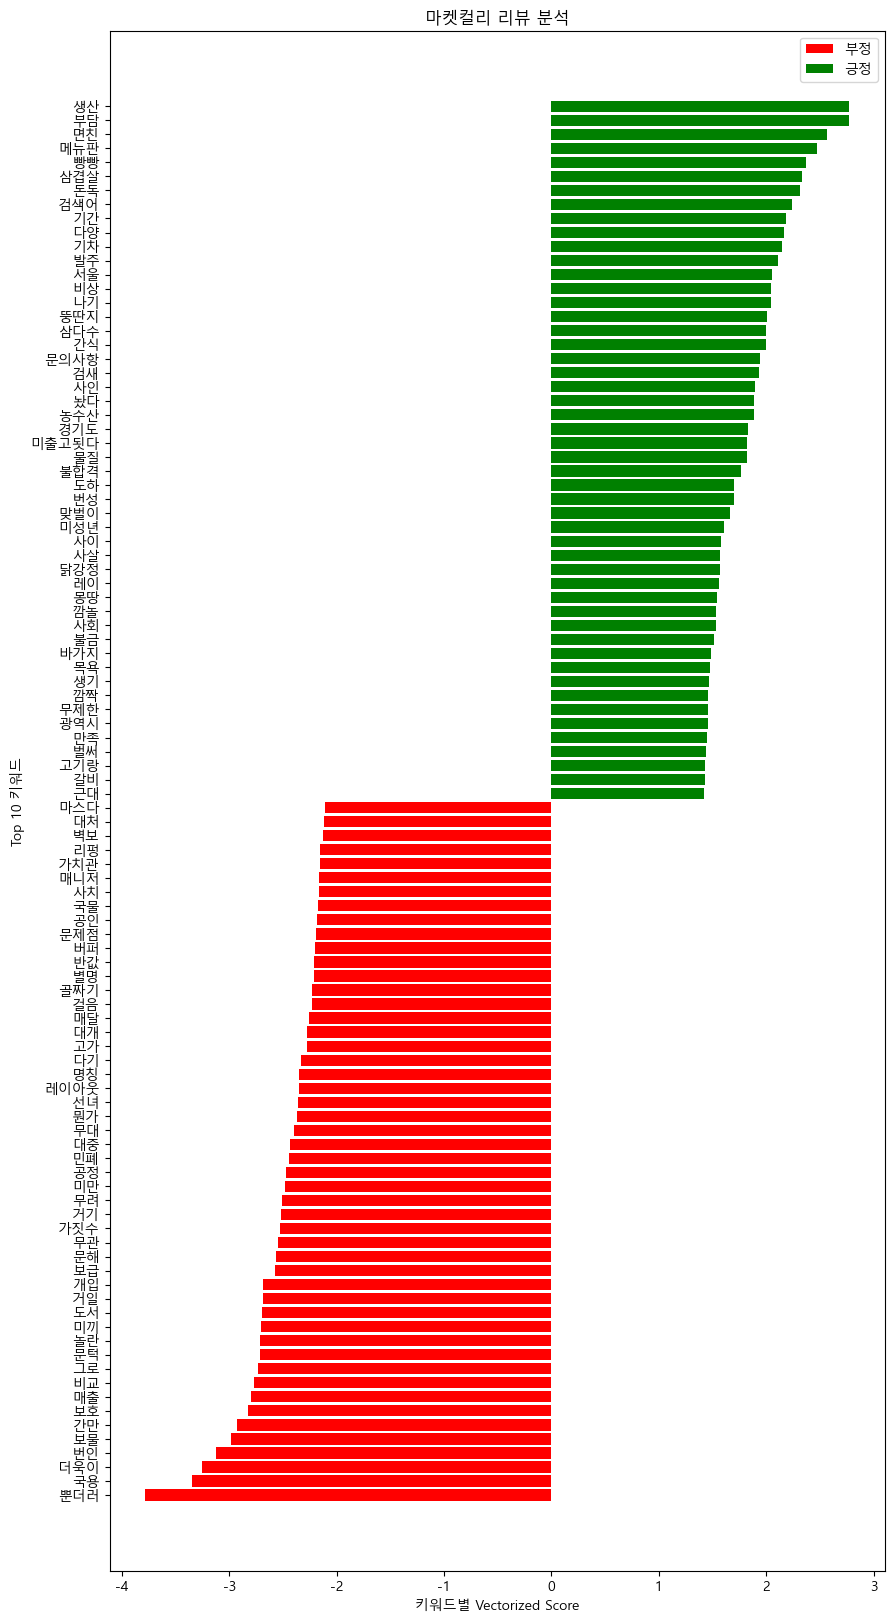

In [282]:
plt.figure(figsize=[10, 20])
plt.barh(neg_top_word, neg_top_score, label = "부정", color = 'r')
plt.barh(pos_top_word, pos_top_score, label = "긍정", color = 'g')
plt.legend()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
plt.xlabel('키워드별 Vectorized Score')
plt.ylabel('Top 10 키워드')
plt.title('마켓컬리 리뷰 분석')
plt.show()

위 키워드 보고 불용어 사전에 추가(위 시각화 여러번 재실행하여 재학습 전 충분히 제거) -> 재학습 -> Top 10에 유의미한 명사 남을 때 까지 반복

In [283]:
# 위 키워드를 보고, 남길 단어만 go_words_input에 수기 입력, 이외 나머지는 불용어 처리

go_words_input = '국용 국물 농수산 검색어'
go_words = go_words_input.split()

stopwords_to_add =  [word for word in neg_top_word if word not in go_words] + \
                    [word for word in pos_top_word if word not in go_words]

with open("stopwords.txt", "a", encoding="utf-8") as f:
    for word in stopwords_to_add:
        f.write(word + "\n")

---

## 오즈비

```
a = x라는 단어가 긍정 리뷰에 있는 경우
b = x라는 단어가 긍정 리뷰에 없는 경우
c = x라는 단어가 부정 리뷰에 있는 경우
d = x라는 단어가 부정 리뷰에 없는 경우

Odds_ratio = (a/b) / (c/d)
```

In [230]:
import math

pos_odds_ratio = [math.exp(score) for score in pos_top_score]
neg_odds_ratio = [math.exp(score) for score in neg_top_score]

pos_odds_df = pd.DataFrame({'긍정리뷰': pos_top_word, '긍정오즈비': pos_odds_ratio,})
pos_odds_df = pos_odds_df.sort_values(by='긍정오즈비', ascending=False)
pos_odds_df = pos_odds_df.reset_index(drop=True)

neg_odds_df = pd.DataFrame({'부정리뷰': neg_top_word, '부정오즈비': neg_odds_ratio})
neg_odds_df = neg_odds_df.sort_values(by='부정오즈비', ascending=False)
neg_odds_df = neg_odds_df.reset_index(drop=True)


In [231]:
pos_odds_df.head(10)

,긍정리뷰,긍정오즈비
0,대체,38.012566
1,깨끗,28.769378
2,두기,26.991760
3,깊이,19.869389
4,계해,14.939051
5,경향신문,14.883425
6,독려,10.244124
7,단골,8.756283
8,과일,8.695327
9,눈물,8.587540


In [232]:
neg_odds_df.head(10)

,부정리뷰,부정오즈비
0,달라,0.076396
1,단종,0.075808
2,감동,0.075437
3,객관,0.073044
4,기절,0.072178
5,거도,0.070741
6,경남,0.069355
7,강조,0.067675
8,나흘,0.064060
9,녹지,0.061363


---

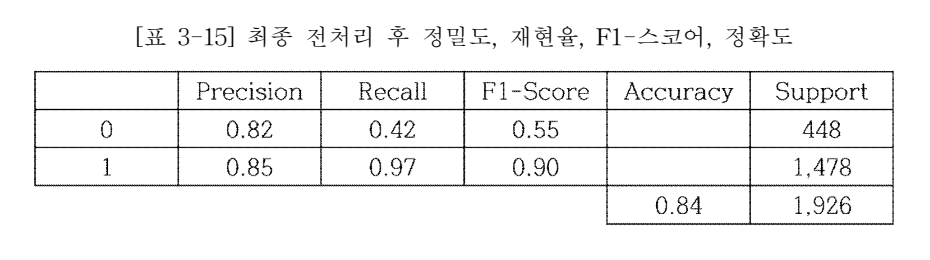

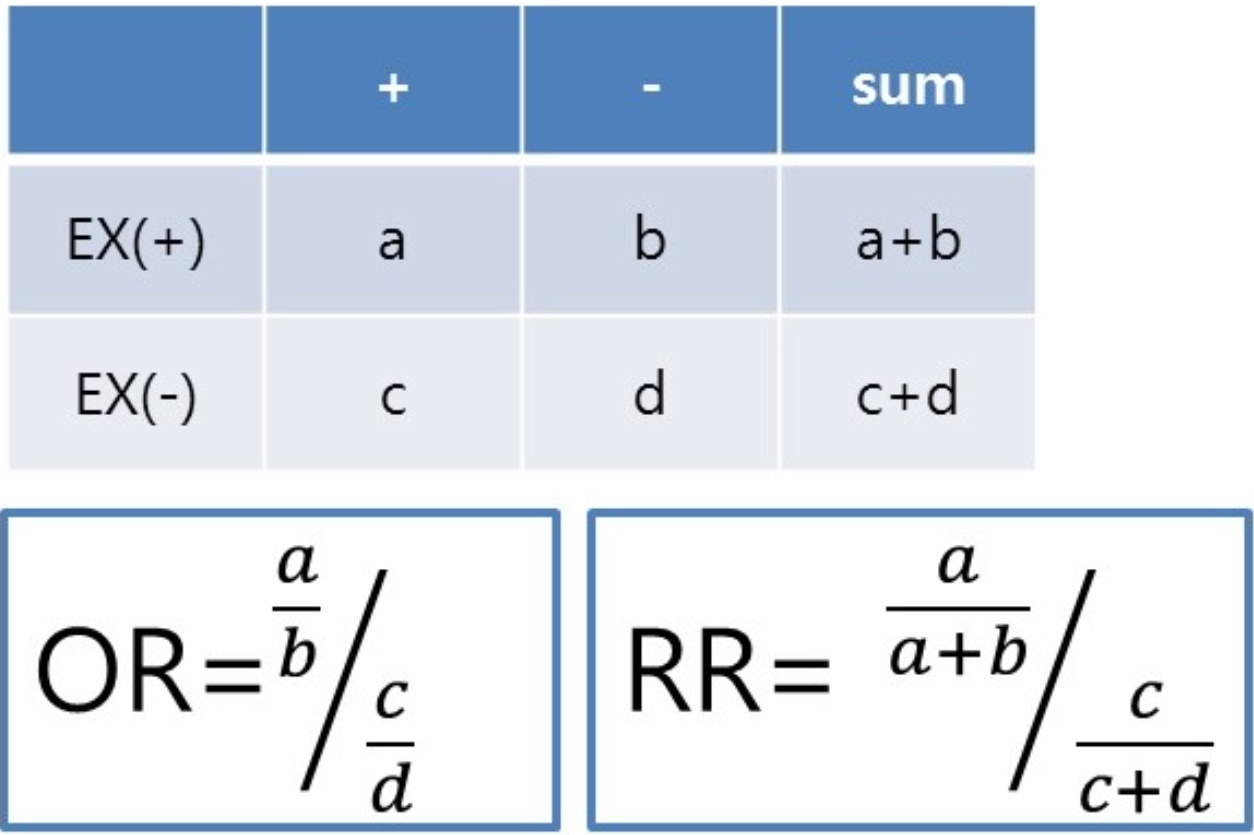

#### chat gpt

로지스틱 회귀 분석의 계수(coef)가 특정 단어에 대해 3이라면, 이 단어의 오즈비는 e^3으로 계산됩니다.

기존의 coef가 아래와 같을 때:

신선: 3
편리: 2.15
간편: 1.85
...
오즈비로 변환하면 다음과 같습니다:

신선: e^3 = 20.0855
편리: e^2.15 = 8.6 (계산 결과는 근사치)
간편: e^1.85 = 6.3 (계산 결과는 근사치)
...
여기서 오즈비 값은 각 단어가 해당 이벤트(긍정 또는 부정 리뷰)와 얼마나 관련이 있는지를 나타내는 지표로 해석됩니다. 예를 들어 "신선"이라는 단어가 있을 때 긍정 리뷰일 확률이 20배 더 높다는 것을 의미합니다.



e^(coef)와 math.exp(coef)는 둘 다 동일한 연산을 수행합니다. 여기서 e는 자연 상수로 약 2.71828의 값을 갖는 수입니다.

이해를 돕기 위해, 로지스틱 회귀와 오즈비의 관계에 대해 설명드리겠습니다.

로지스틱 회귀(Logistic Regression)

로지스틱 회귀는 종속 변수가 이진 변수(0 또는 1)인 경우 사용되는 회귀 분석 방법입니다.
선형 회귀와 달리 로지스틱 회귀는 결과값을 0과 1 사이로 제한합니다. 이를 위해 로지스틱 함수(또는 시그모이드 함수)를 사용합니다.
오즈(Odds)

사건이 발생할 확률(p)에 대해 오즈는 p / (1-p)로 정의됩니다.
예를 들어, 어떤 사건이 발생할 확률이 0.75라면 그 오즈는 0.75 / (1-0.75) = 3입니다.
오즈비(Odds Ratio)

두 그룹 간의 오즈의 비율입니다.
로지스틱 회귀에서는 특정 변수(예: X1)의 계수가 1 단위 증가할 때 그룹 간의 오즈비가 얼마나 변하는지 설명해줍니다.
로지스틱 회귀의 계수와 오즈비의 관계

로지스틱 회귀에서 얻은 계수는 로그 오즈비(log odds ratio)에 해당합니다.
따라서, 계수를 e의 지수로 사용하면 오즈비를 얻을 수 있습니다. 즉, 오즈비 = e^(coef)가 됩니다.
요약하면, 로지스틱 회귀에서 계수는 로그 오즈비를 나타냅니다. 이를 자연 로그의 밑인 e의 지수로 사용하면 원래의 오즈비를 구할 수 있습니다.

In [115]:
# 오즈비 삽질

def odds_ratio_calculator(word, review_df):
    pos_reviews = review_df[review_df['label'] == 1]['reviews_for_vectorize'].tolist()
    neg_reviews = review_df[review_df['label'] == 0]['reviews_for_vectorize'].tolist()
    
    a = sum(1 for review in pos_reviews if word in review)
    b = len(pos_reviews) - a
   
    c = sum(1 for review in neg_reviews if word in review)
    d = len(neg_reviews) - c
    
    if a==0 or b==0 or c==0 or d==0:
        return "해당 단어는 리뷰리스트에 존재하지 않거나 제거되었음."

    odds_ratio = (a / b) / (c / d)
    
    return odds_ratio

In [133]:
word = '이슈'
odds_ratio_calculator(word, review_df)

0.04236351718325686

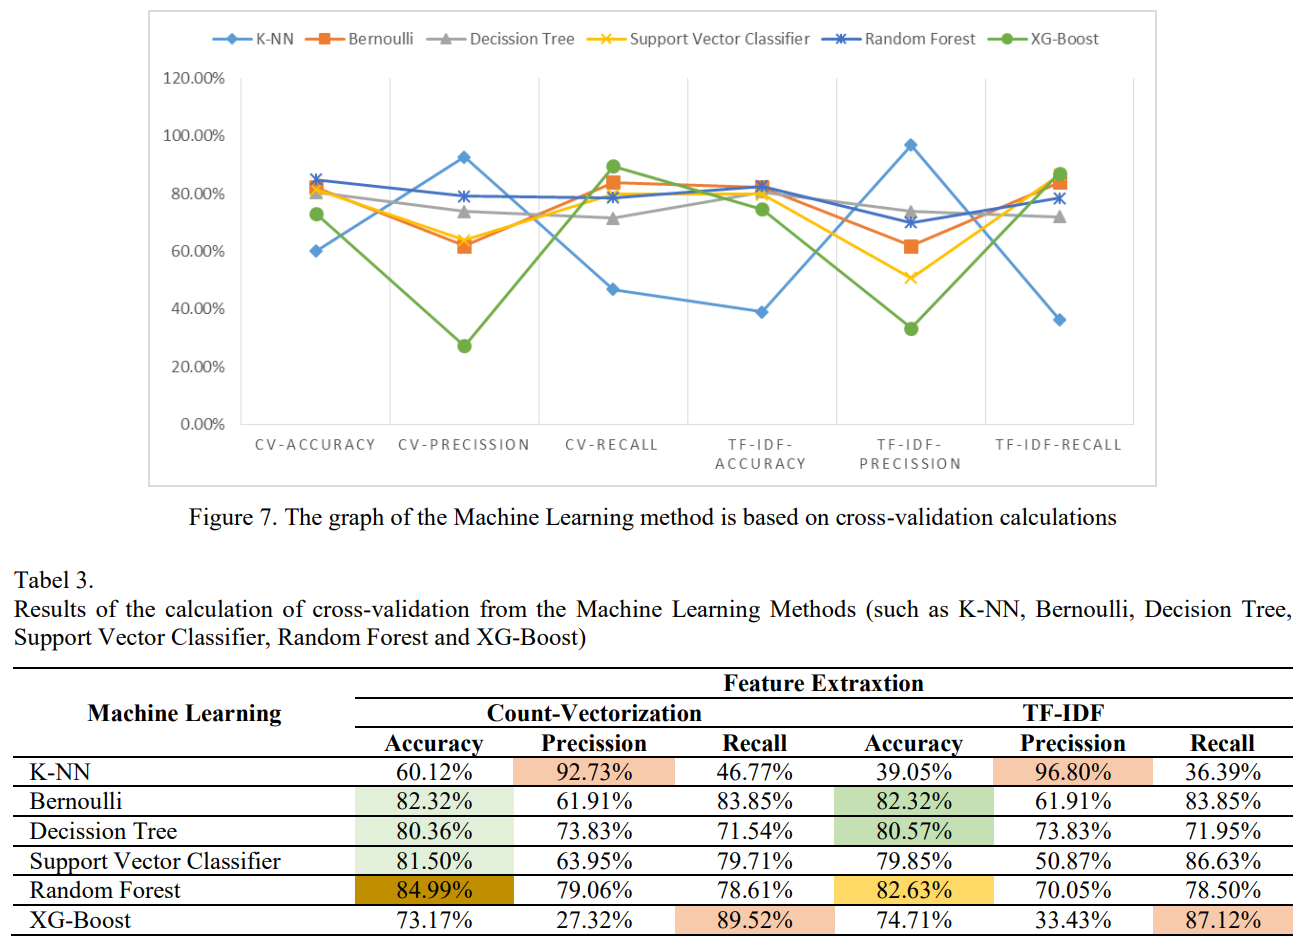